## Imports and adding the starting dataset

In [3]:
# Imports
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Descriptors
from map4 import MAP4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis  # In case of regression analysis
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from skfp.fingerprints import PubChemFingerprint, ECFPFingerprint, RDKit2DDescriptorsFingerprint, MAPFingerprint

c:\Users\ASUS\miniconda3\envs\qsar\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Here is where you add your starting dataset
df_raw = pd.read_csv("C:/QSAR/code/combined_chembel_bindingdb_dataset.csv")

In [5]:
# Adding a column named "set". It will be used in the next part
df_raw['set'] = 'train'
df_raw.to_csv("C:/QSAR/code/combined_chembel_bindingdb_dataset_updated.csv", index=False)

In [6]:
df_raw.head()

,SMILES,IC50_nM,pIC50,dataset,Activity,set
0,c1ccc(OCCNc2ccc(-c3nc4ccccc4o3)cc2)cc1,75900.0,4.119758,BindingDB,0,train
1,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,38000.0,4.420216,BindingDB,0,train
2,C=C(C)c1cc(C#N)cc2nc(-c3ccc(C(=O)NCC4CCN(c5ccc...,131.0,6.882729,BindingDB,0,train
3,CC(=O)C1=C(C(C)=O)C(C(C)=O)C=C2OC3CC[C@@]4(C)C...,23000.0,4.638272,BindingDB,0,train
4,CC(=O)Nc1ccccc1SSc1ccccc1NC(C)=O,500000.0,3.301030,BindingDB,0,train


In [7]:
df_raw.shape

(1423, 6)

## Define helper functions 

In [8]:
def find_smiles_column(df):
    smiles_variants = ['smiles', 'Smiles', 'SMILES', 'smile', 'Smile', 'SMILE']
    for col in df.columns:
        if col.lower() in [variant.lower() for variant in smiles_variants]:
            return col
    raise ValueError("No SMILES column found in the DataFrame")

def calculate_molecular_features(mols):
    if not all(isinstance(mol, Chem.Mol) for mol in mols if mol is not None):
        raise ValueError("Input 'mols' must be a list of valid RDKit molecule objects")
    feature_dic = {
        'PubChem': PubChemFingerprint(),
        'ECFP': ECFPFingerprint(radius=2),
        'RDKit2D': RDKit2DDescriptorsFingerprint(),
        'MAP4': MAPFingerprint(fp_size=2048),
    }
    all_data = {}
    for feature_type in feature_dic:
        func = feature_dic[feature_type]
        try:
            feature_values = func.transform(mols)
            feature_names = func.get_feature_names_out()
            feature_df = pd.DataFrame(feature_values, columns=feature_names)
            all_data[feature_type] = feature_df
        except Exception as e:
            print(f"Error computing {feature_type}: {e}")
            continue
    return all_data

def perform_xgb_cv(dtrain, params, additional_info):
    cv_result = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        nfold=5,
        metrics='aucpr',
        early_stopping_rounds=50,
        seed=42,
        stratified=True
    )
    best_iteration = cv_result['test-aucpr-mean'].argmax()
    best_aucpr = cv_result['test-aucpr-mean'].max()
    auc = cv_result['test-auc-mean'][best_iteration] if 'test-auc-mean' in cv_result else None
    result = {
        'best_aucpr': best_aucpr,
        'auc': auc,
        'best_iteration': best_iteration,
        'params': params
    }
    result.update(additional_info)
    return result

In [10]:
def find_split_column(df):
    split_variants = ['set', 'split','Set', 'Split']
    for col in df.columns:
        if col.lower() in [variant.lower() for variant in split_variants]:
            return col
    raise ValueError("No split column (e.g., dataset, set, split) found in the DataFrame")


## Data Analysis

In [9]:
def analyze_data(df, target_col='Activity'):
    """
    Analyze the target column for regression or classification, using a pie chart for classification
    with detailed classifier recommendations.
    
    Args:
        df (pd.DataFrame): DataFrame with target column.
        target_col (str): Name of the target column.
    
    Returns:
        dict: Statistics or class analysis.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import skew, kurtosis
    
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame")
    target = df[target_col].dropna()
    
    # Force classification analysis for 'activity' or 'Activity' columns
    if target_col.lower() in ['activity', 'Activity']:
        # Ensure target is treated as categorical
        target = target.astype(str)  # Convert to string to force categorical
        class_counts = target.value_counts()
        class_balance = class_counts / len(target)
        print("\n=== Target Column Analysis (Classification) ===")
        print("Class Counts:")
        print(class_counts)
        print("Class Balance:")
        print(class_balance)
        # Pie chart for class distribution
        plt.figure(figsize=(8, 6))
        plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, 
                colors=sns.color_palette('Set2', len(class_counts)))
        plt.title('Distribution of Target Classes')
        plt.savefig('target_class_distribution.png')
        plt.show()
        suggestions = []
        # General suggestions based on data
        if len(class_counts) < 2:
            suggestions.append("Only one class: Not suitable for classification; check data.")
        elif min(class_balance) < 0.1:
            suggestions.append("Severe class imbalance (<10% minority class): Use oversampling (SMOTE), undersampling, or class weights in models like XGBoost, RandomForest, or LogisticRegression.")
        elif min(class_balance) < 0.3:
            suggestions.append("Moderate class imbalance (<30% minority class): Use class_weight='balanced' in RandomForest, LogisticRegression, SVM, or GradientBoostingClassifier, or scale_pos_weight in XGBoost.")
        else:
            suggestions.append("Balanced classes (~40-60% split): Standard classifiers like RandomForest, XGBoost, or LogisticRegression should perform well.")
        if len(target.unique()) > 2:
            suggestions.append("Multi-class classification: Use models supporting multi-class, e.g., RandomForest, XGBoost (with softmax), or GradientBoostingClassifier.")
        else:
            suggestions.append("Binary classification: Suitable for LogisticRegression, RandomForest, XGBoost, SVM, or GradientBoostingClassifier.")
        if len(target) < 100:
            suggestions.append("Small sample size (<100): Prefer simpler models like LogisticRegression or RandomForest to avoid overfitting.")
        elif len(target) < 10000:
            suggestions.append("Moderate sample size (<10000): All classifiers (RandomForest, XGBoost, LogisticRegression, SVM, GradientBoostingClassifier) are suitable.")
        
        # Classifier-specific recommendations
        suggestions.append("\n=== Classifier Recommendations ===")
        suggestions.append("1. RandomForestClassifier:")
        suggestions.append("   - Description: Ensemble of decision trees, averages predictions to reduce overfitting. Robust to high-dimensional data.")
        suggestions.append("   - Strengths: Handles non-linear relationships, robust to outliers, provides feature importance. Good for QSAR fingerprints.")
        suggestions.append("   - Weaknesses: Slower on very large datasets; less interpretable than linear models.")
        suggestions.append("   - Suitability: Excellent for binary, high-dimensional fingerprints (ECFP, PubChem, MAP4, RDKit2D). Use if class balance is ~40-60% or slightly imbalanced.")
        suggestions.append("   - Tip: Set class_weight='balanced' for imbalance (check pie chart).")
        
        suggestions.append("2. LogisticRegression:")
        suggestions.append("   - Description: Linear model predicting probability of binary outcome. Assumes linear feature relationships.")
        suggestions.append("   - Strengths: Fast, interpretable coefficients, effective with standardized features (like RDKit descriptors).")
        suggestions.append("   - Weaknesses: Struggles with non-linear patterns unless features are engineered.")
        suggestions.append("   - Suitability: Good baseline for QSAR if features (post-standardization) have linear discriminative power. Fast for moderate sample size samples.")
        suggestions.append("   - Tip: Use class_weight='balanced' for imbalance; ensure RDKit standardization (Cell 4).")
        
        suggestions.append("3. XGBoostClassifier:")
        suggestions.append("   - Description: Gradient-boosting model building sequential trees to optimize loss. Used in this pipeline for feature selection.")
        suggestions.append("   - Strengths: High accuracy, captures non-linear patterns, implicit feature selection (aligns with SHAP).")
        suggestions.append("   - Weaknesses: Requires tuning (eta, max_depth); slower than RandomForest.")
        suggestions.append("   - Suitability: Likely best for QSAR with complex molecular patterns and moderate sample size samples. Robust to imbalance.")
        suggestions.append("   - Tip: Use scale_pos_weight for imbalance (minority/majority ratio from pie chart).")
        
        suggestions.append("4. SVM (Support Vector Machine):")
        suggestions.append("   - Description: Finds optimal hyperplane to separate classes, using kernels (e.g., RBF) for non-linear data.")
        suggestions.append("   - Strengths: Effective for high-dimensional, sparse fingerprints; robust to outliers with RBF kernel.")
        suggestions.append("   - Weaknesses: Slow on large datasets (>10,000); sensitive to feature scaling.")
        suggestions.append("   - Suitability: Good for moderate sample size samples if non-linear patterns dominate. May underperform XGBoost.")
        suggestions.append("   - Tip: Use class_weight='balanced' and RBF kernel; ensure RDKit standardization.")
        
        suggestions.append("5. GradientBoostingClassifier:")
        suggestions.append("   - Description: Simpler gradient-boosting model than XGBoost, building sequential trees.")
        suggestions.append("   - Strengths: Robust to noise, handles non-linear relationships, good for moderate datasets.")
        suggestions.append("   - Weaknesses: Slower and less optimized than XGBoost; requires tuning.")
        suggestions.append("   - Suitability: Viable alternative to XGBoost for QSAR with moderate sample size samples.")
        suggestions.append("   - Tip: Use class_weight='balanced' for imbalance; try if XGBoost tuning is complex.")
        
        print("\n".join(suggestions))
        return {'class_counts': class_counts, 'class_balance': class_balance, 'suggestions': suggestions}
    else:
        # Regression analysis (kept for completeness)
        if not np.issubdtype(target.dtype, np.number):
            raise ValueError(f"Target column '{target_col}' must be numeric for regression")
        stats = {
            'mean': target.mean(),
            'std': target.std(),
            'min': target.min(),
            'max': target.max(),
            'skewness': skew(target),
            'kurtosis': kurtosis(target),
            'num_samples': len(target)
        }
        print("\n=== Target Column Statistics (Regression) ===")
        for key, value in stats.items():
            print(f"{key.capitalize()}: {value:.4f}")
        plt.figure(figsize=(8, 6))
        sns.histplot(target, kde=True, bins=30)
        plt.title('Distribution of Target Values')
        plt.xlabel('Target')
        plt.ylabel('Frequency')
        plt.savefig('target_distribution.png')
        plt.show()
        suggestions = []
        if abs(stats['skewness']) < 0.5:
            suggestions.append("Low skewness: Linear models (e.g., LinearRegression) may perform well if relationships are linear.")
        else:
            suggestions.append("High skewness: Non-linear models like RandomForest or XGBoost are recommended.")
        if stats['kurtosis'] > 3:
            suggestions.append("High kurtosis: Robust models like XGBoost with regularization.")
        else:
            suggestions.append("Moderate kurtosis: Standard regressors like XGBoost.")
        if stats['num_samples'] < 100:
            suggestions.append("Small sample size: Simple models to avoid overfitting.")
        mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES'] if Chem.MolFromSmiles(smiles)]
        if mols:
            mol_wts = [Descriptors.MolWt(mol) for mol in mols]
            if len(mol_wts) == len(target):
                corr = np.corrcoef(mol_wts, target)[0, 1]
                print(f"Correlation between MolWt (example feature) and target: {corr:.4f}")
                if abs(corr) > 0.7:
                    suggestions.append("High correlation with example feature: Linear models might work.")
                else:
                    suggestions.append("Low correlation with example feature: Non-linear models preferred.")
        print("\n=== Regressor Suggestions ===")
        for sug in suggestions:
            print(f"- {sug}")
        return {'stats': stats, 'suggestions': suggestions}


=== Target Column Analysis (Classification) ===
Class Counts:
Activity
0    1069
1     354
Name: count, dtype: int64
Class Balance:
Activity
0    0.75123
1    0.24877
Name: count, dtype: float64


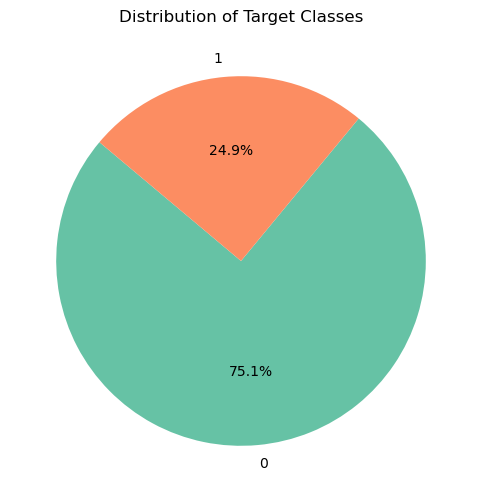

Moderate class imbalance (<30% minority class): Use class_weight='balanced' in RandomForest, LogisticRegression, SVM, or GradientBoostingClassifier, or scale_pos_weight in XGBoost.
Binary classification: Suitable for LogisticRegression, RandomForest, XGBoost, SVM, or GradientBoostingClassifier.
Moderate sample size (<10000): All classifiers (RandomForest, XGBoost, LogisticRegression, SVM, GradientBoostingClassifier) are suitable.

=== Classifier Recommendations ===
1. RandomForestClassifier:
   - Description: Ensemble of decision trees, averages predictions to reduce overfitting. Robust to high-dimensional data.
   - Strengths: Handles non-linear relationships, robust to outliers, provides feature importance. Good for QSAR fingerprints.
   - Weaknesses: Slower on very large datasets; less interpretable than linear models.
   - Suitability: Excellent for binary, high-dimensional fingerprints (ECFP, PubChem, MAP4, RDKit2D). Use if class balance is ~40-60% or slightly imbalanced.
   - Tip

In [11]:
# Cell 3: Load and Analyze Data (Updated to Select SMILES, Activity, dataset)
def load_and_analyze_data(df_raw, activity_col='Activity'):
    """
    Select SMILES, Activity, and split column, handle invalid SMILES, and perform data analysis.
    
    Args:
        df_raw (pd.DataFrame): Input DataFrame with SMILES, Activity, and split column (e.g., dataset).
        activity_col (str): Name of the activity column (default: 'Activity').
    
    Returns:
        pd.DataFrame: Processed DataFrame with SMILES, Activity, set.
        list: List of valid RDKit molecule objects.
    """
    smiles_col = find_smiles_column(df_raw)
    split_col = find_split_column(df_raw)
    if activity_col not in df_raw.columns:
        raise ValueError(f"Activity column '{activity_col}' not found in DataFrame")
    
    # Select only SMILES, Activity, and split column
    df_combine = df_raw[[smiles_col, activity_col, split_col]].rename(columns={smiles_col: 'SMILES', split_col: 'set'})
    analyze_data(df_combine, target_col=activity_col)
    mols = [Chem.MolFromSmiles(smiles) for smiles in df_combine['SMILES']]
    valid_idx = [i for i, mol in enumerate(mols) if mol is not None]
    df_combine = df_combine.iloc[valid_idx].reset_index(drop=True)
    mols = [mols[i] for i in valid_idx]
    return df_combine, mols


# Execute
df_combine, mols = load_and_analyze_data(df_raw, activity_col='Activity')

## Adding features

In [12]:
from sklearn.preprocessing import StandardScaler

def add_molecular_features(df_combine, mols):
    """
    Compute molecular features and concatenate to the DataFrame.
    
    Args:
        df_combine (pd.DataFrame): DataFrame with SMILES.
        mols (list): List of RDKit molecule objects.
    
    Returns:
        pd.DataFrame: DataFrame with all features added.
    """
    fingerprint_dic = calculate_molecular_features(mols)
    PubChem = fingerprint_dic['PubChem']
    ECFP = fingerprint_dic['ECFP']
    rdkit_dec = fingerprint_dic['RDKit2D']
    Map4 = fingerprint_dic['MAP4']
    rdkit_dec.columns = [f'rdkit_{col}' for col in rdkit_dec.columns]
    df_all = pd.concat([df_combine, ECFP, PubChem, rdkit_dec, Map4], axis=1)

    # Standardize only RDKit columns (continuous features)
    rdkit_cols = [col for col in df_all.columns if col.startswith('rdkit_')]
    scaler = StandardScaler()
    df_all[rdkit_cols] = scaler.fit_transform(df_all[rdkit_cols])

    df_all.to_csv("data_with_all_features.csv", index=False)
    return df_all

# Execute
df_all = add_molecular_features(df_combine, mols)

In [13]:
df_all.head()

,SMILES,Activity,set,ecfpfingerprint0,ecfpfingerprint1,ecfpfingerprint2,ecfpfingerprint3,ecfpfingerprint4,ecfpfingerprint5,ecfpfingerprint6,...,mapfingerprint2038,mapfingerprint2039,mapfingerprint2040,mapfingerprint2041,mapfingerprint2042,mapfingerprint2043,mapfingerprint2044,mapfingerprint2045,mapfingerprint2046,mapfingerprint2047
0,c1ccc(OCCNc2ccc(-c3nc4ccccc4o3)cc2)cc1,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...,0,train,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2,C=C(C)c1cc(C#N)cc2nc(-c3ccc(C(=O)NCC4CCN(c5ccc...,0,train,0,0,0,0,0,0,0,...,1,1,1,0,1,0,1,0,0,1
3,CC(=O)C1=C(C(C)=O)C(C(C)=O)C=C2OC3CC[C@@]4(C)C...,0,train,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,CC(=O)Nc1ccccc1SSc1ccccc1NC(C)=O,0,train,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [14]:
def prepare_fingerprint_dfs(df_all, activity_col='Activity'):
    """
    Create separate DataFrames for each fingerprint type.
    
    Args:
        df_all (pd.DataFrame): DataFrame with SMILES, Activity, set, and features.
        activity_col (str): Name of the activity column.
    
    Returns:
        list: List of fingerprint DataFrames.
        list: List of fingerprint names.
    """
    x_rdkit = df_all.filter(regex='rdkit_')
    x_ECFP = df_all.filter(regex='ecfp')
    x_pubchem = df_all.filter(regex='pubchem')
    x_map = df_all.filter(regex='map')
    list_df = [x_ECFP, x_pubchem, x_rdkit, x_map]
    for i in range(len(list_df)):
        list_df[i] = pd.concat([df_all[['SMILES', activity_col, 'set']], list_df[i]], axis=1)
    fingerprint_dfs = list_df + [df_all]
    fingerprint_names = ['x_ECFP', 'x_pubchem', 'x_rdkit', 'x_map', 'df_all']
    return fingerprint_dfs, fingerprint_names

# Execute
fingerprint_dfs, fingerprint_names = prepare_fingerprint_dfs(df_all, activity_col='Activity')

In [15]:
# Number of features added by each:

x_rdkit = df_all.filter(regex='rdkit_')
x_ECFP = df_all.filter(regex='ecfp')
x_pubchem = df_all.filter(regex='pubchem')
x_map = df_all.filter(regex='map')

print(f"Number of features added:\nRDKit: {len(x_rdkit.columns)} \nECFP: {len(x_ECFP.columns)}\nPubchem: {len(x_pubchem.columns)}\nx_map: {len(x_map.columns)} ")

Number of features added:
RDKit: 200 
ECFP: 2048
Pubchem: 881
x_map: 2048 


## Feature Selection

In [18]:
def tune_hyperparameters(df_all, activity_col='Activity'):
    """
    Perform hyperparameter tuning with CV for classification.
    
    Args:
        df_all (pd.DataFrame): DataFrame with SMILES, Activity, set, and features.
        activity_col (str): Name of the activity column.
    
    Returns:
        dict: Best parameters.
        int: Best iteration.
    """
    # Check unique values in Activity
    unique_values = df_all[activity_col].astype(str).unique()
    print(f"Unique values in '{activity_col}': {unique_values}")
    
    # Check if Activity is already numeric (0/1)
    try:
        df_all[activity_col] = df_all[activity_col].astype(int)
        unique_numeric = df_all[activity_col].unique()
        if set(unique_numeric).issubset({0, 1}):
            print(f"'{activity_col}' is already numeric (0/1); no mapping needed.")
        else:
            raise ValueError(f"'{activity_col}' contains numeric values {unique_numeric}, but only 0/1 are allowed.")
    except (ValueError, TypeError):
        # Try string-based mapping
        positive_labels = ['active', 'positive', '1', 'True', 'yes']
        negative_labels = ['inactive', 'negative', '0', 'False', 'no']
        if len(unique_values) != 2:
            raise ValueError(f"Expected exactly 2 unique values in '{activity_col}', got {len(unique_values)}: {unique_values}")
        mapping = {}
        for val in unique_values:
            val_lower = str(val).lower()
            if val_lower in positive_labels:
                mapping[val] = 1
            elif val_lower in negative_labels:
                mapping[val] = 0
            else:
                raise ValueError(f"Unrecognized value '{val}' in '{activity_col}'. Expected binary labels (e.g., 'active'/'inactive', 'positive'/'negative', 0/1).")
        df_all[activity_col] = df_all[activity_col].map(mapping)
    
    if df_all[activity_col].isna().any():
        raise ValueError(f"Failed to map some '{activity_col}' values to 0/1. Unmapped values: {df_all[df_all[activity_col].isna()][activity_col].unique()}")
    
    feature_diff = ['SMILES', activity_col, 'set']
    FEATURES = df_all.columns.difference(feature_diff).tolist()
    dtrain = xgb.DMatrix(
        df_all.loc[df_all['set'] == 'train', FEATURES].values,
        label=df_all.loc[df_all['set'] == 'train', activity_col].values
    )
    params = [
        {'objective': 'binary:logistic', 'eta': 0.1, 'max_depth': 6, 'eval_metric': 'aucpr'},
        {'objective': 'binary:logistic', 'eta': 0.05, 'max_depth': 4, 'eval_metric': 'aucpr'},
        {'objective': 'binary:logistic', 'eta': 0.2, 'max_depth': 8, 'eval_metric': 'aucpr'}
    ]
    cv_results = []
    for params_id, train_params in enumerate(params):
        result = perform_xgb_cv(
            dtrain, train_params, additional_info={
                'num_features': dtrain.num_col(),
                'n_dtrain': dtrain.num_row(),
                'params_id': params_id
            })
        cv_results.append(result)
    res = pd.DataFrame(cv_results)
    res = res.sort_values('best_aucpr', ascending=False)
    print("\n=== Hyperparameter Tuning Results ===")
    print(res)
    best_row = res.iloc[0]
    best_params = best_row['params']
    best_iteration = int(best_row['best_iteration'])
    print("Best params:", best_params)
    print("Best iteration:", best_iteration)
    print("Best AUCPR:", best_row['best_aucpr'])
    return best_params, best_iteration
# Execute
best_params, best_iteration = tune_hyperparameters(df_all, activity_col='Activity')

Unique values in 'Activity': ['0' '1']
'Activity' is already numeric (0/1); no mapping needed.

=== Hyperparameter Tuning Results ===
   best_aucpr   auc  best_iteration  \
1    0.768387  None             188   
0    0.766766  None              37   
2    0.761930  None              54   

                                              params  num_features  n_dtrain  \
1  {'objective': 'binary:logistic', 'eta': 0.05, ...          5177      1423   
0  {'objective': 'binary:logistic', 'eta': 0.1, '...          5177      1423   
2  {'objective': 'binary:logistic', 'eta': 0.2, '...          5177      1423   

   params_id  
1          1  
0          0  
2          2  
Best params: {'objective': 'binary:logistic', 'eta': 0.05, 'max_depth': 4, 'eval_metric': 'aucpr'}
Best iteration: 188
Best AUCPR: 0.7683870835109172


In [19]:
def compute_shap_values(df_all, best_params, best_iteration, activity_col='activity'):
    """
    Train the XGBoost model and compute SHAP values.
    
    Args:
        df_all (pd.DataFrame): DataFrame with all features.
        best_params (dict): Best hyperparameters.
        best_iteration (int): Best iteration from CV.
        activity_col (str): Name of the activity column.
    
    Returns:
        dict: SHAP values storage.
    """
    feature_diff = ['Name', 'SMILES', activity_col, 'set']
    FEATURES = df_all.columns.difference(feature_diff).tolist()
    dtrain = xgb.DMatrix(
        df_all.loc[df_all['set'] == 'train', FEATURES].values,
        label=df_all.loc[df_all['set'] == 'train', activity_col].values
    )
    model = xgb.train(best_params, dtrain, best_iteration)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(dtrain)
    feature_importance = np.abs(shap_values).mean(axis=0)
    shap_values_storage = {
        'shap_values': feature_importance,
        'feature_names': FEATURES
    }
    shap_df = pd.DataFrame({
        'feature': shap_values_storage['feature_names'],
        'shap_value': shap_values_storage['shap_values']
    })
    print("\n=== Top 40 Features by SHAP Value ===")
    print(shap_df.sort_values(by='shap_value', ascending=False).head(40))
    num_zero_shap = len(shap_df[shap_df['shap_value'] == 0])
    print(f"Features with SHAP = 0: {num_zero_shap}")
    return shap_values_storage

# Execute
shap_values_storage = compute_shap_values(df_all, best_params, best_iteration, activity_col='Activity')


=== Top 40 Features by SHAP Value ===
                      feature  shap_value
2610       mapfingerprint1503    0.208704
534       ecfpfingerprint1479    0.207624
5003   rdkit_FpDensityMorgan1    0.194104
3248        mapfingerprint235    0.147562
3735        mapfingerprint674    0.122825
5015  rdkit_MaxAbsEStateIndex    0.113451
3798        mapfingerprint730    0.102812
5014          rdkit_LabuteASA    0.101459
5002         rdkit_ExactMolWt    0.100284
3322        mapfingerprint301    0.092924
2339        mapfingerprint126    0.087547
5084        rdkit_VSA_EState3    0.085582
4978            rdkit_BertzCT    0.080993
2332       mapfingerprint1253    0.078923
3452        mapfingerprint419    0.078859
2165       mapfingerprint1102    0.077463
3685        mapfingerprint629    0.076997
2526       mapfingerprint1428    0.076718
5000        rdkit_EState_VSA8    0.075931
5089        rdkit_VSA_EState8    0.074209
5036     rdkit_NumHeteroatoms    0.070359
2548       mapfingerprint1448    0.06

In [20]:
# Cell 8: Perform Feature Selection (Updated feature_diff)
def perform_feature_selection(df_all, shap_values_storage, best_params, fingerprint_dfs, fingerprint_names, activity_col='Activity'):
    """
    Select features using SHAP percentiles, perform CV, update fingerprint_dfs, and save the selected dataset.
    
    Args:
        df_all (pd.DataFrame): DataFrame with SMILES, Activity, set, and features.
        shap_values_storage (dict): SHAP values and feature names.
        best_params (dict): Best hyperparameters.
        fingerprint_dfs (list): List of fingerprint DataFrames.
        fingerprint_names (list): List of fingerprint names.
        activity_col (str): Name of the activity column.
    
    Returns:
        pd.DataFrame: DataFrame with selected features.
        list: Updated fingerprint_dfs with df_selected.
        list: Updated fingerprint_names with 'df_selected'.
    """
    percentiles = [97, 96, 95, 94, 50]
    filtered_features = {}
    shap_values_arr = np.array(shap_values_storage['shap_values'])
    feature_names = shap_values_storage['feature_names']
    shap_thresholds = np.percentile(shap_values_arr, percentiles)
    for threshold, percentile in zip(shap_thresholds, percentiles):
        features_above_threshold = [
            feature_names[i] for i, val in enumerate(shap_values_arr)
            if val > threshold
        ]
        filtered_features[percentile] = features_above_threshold
        print(f"Percentile: {percentile}, Number of features: {len(features_above_threshold)}")
    cv_results = []
    for threshold, selected_features in filtered_features.items():
        if not selected_features:
            continue
        dtrain_filtered = xgb.DMatrix(
            df_all.loc[df_all['set'] == 'train', selected_features].values,
            label=df_all.loc[df_all['set'] == 'train', activity_col].values
        )
        result = perform_xgb_cv(
            dtrain_filtered, best_params, additional_info={
                'num_features': dtrain_filtered.num_col(),
                'n_dtrain': dtrain_filtered.num_row(),
                'threshold': threshold
            })
        cv_results.append(result)
    res = pd.DataFrame(cv_results)[['threshold', 'best_aucpr', 'auc', 'best_iteration', 'num_features', 'n_dtrain']]
    res = res.sort_values(by='best_aucpr', ascending=False)
    print("\n=== Feature Selection CV Results ===")
    print(res)
    best_auc_row = res.iloc[0]
    best_threshold = best_auc_row['threshold']
    print("Best threshold:", best_threshold)
    select_fetu = df_all[filtered_features[best_threshold]]
    feature_diff = ['SMILES', activity_col, 'set']
    df_selected = pd.concat([df_all[feature_diff], select_fetu], axis=1)
    df_selected.to_csv("Dataset_with_selected_features.csv", index=False)
    # Update fingerprint_dfs and fingerprint_names
    fingerprint_dfs[-1] = df_selected
    fingerprint_names[-1] = 'df_selected'
    return df_selected, fingerprint_dfs, fingerprint_names
# Execute
df_selected, fingerprint_dfs, fingerprint_names = perform_feature_selection(df_all, shap_values_storage, best_params, fingerprint_dfs, fingerprint_names, activity_col='Activity')

Percentile: 97, Number of features: 156
Percentile: 96, Number of features: 208
Percentile: 95, Number of features: 259
Percentile: 94, Number of features: 311
Percentile: 50, Number of features: 642

=== Feature Selection CV Results ===
   threshold  best_aucpr   auc  best_iteration  num_features  n_dtrain
0         97    0.813305  None             374           156      1423
1         96    0.812098  None             456           208      1423
2         95    0.802552  None             363           259      1423
3         94    0.791918  None             154           311      1423
4         50    0.790921  None             166           642      1423
Best threshold: 97


## Final Comparison

In [21]:
def run_final_comparison_and_plot(fingerprint_dfs, fingerprint_names, activity_col='Activity'):
    """
    Perform final comparison using multiple classifiers and generate plots.
    
    Args:
        fingerprint_dfs (list): List of fingerprint DataFrames.
        fingerprint_names (list): List of fingerprint names.
        activity_col (str): Name of the activity column.
    """
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import recall_score, precision_score, f1_score, matthews_corrcoef
    from sklearn.impute import SimpleImputer
    
    # Define classifiers with class imbalance handling
    models = {
        'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'XGBoost': XGBClassifier(random_state=42, n_estimators=100, eval_metric='aucpr', scale_pos_weight=1069/354)
    }
    
    # Imputer for handling NaN values
    imputer = SimpleImputer(strategy='median')
    
    results = []
    for name, df_fp in zip(fingerprint_names, fingerprint_dfs):
        train_df = df_fp[df_fp['set'] == 'train']
        if len(train_df) < 10:
            print(f"Not enough data for {name}")
            continue
        # Check unique values in Activity
        unique_values = train_df[activity_col].astype(str).unique()
        print(f"Unique values in '{activity_col}' for {name}: {unique_values}")
        
        # Handle labels
        try:
            train_df[activity_col] = train_df[activity_col].astype(int)
            unique_numeric = train_df[activity_col].unique()
            if not set(unique_numeric).issubset({0, 1}):
                print(f"Skipping {name}: '{activity_col}' contains numeric values {unique_numeric}, but only 0/1 are allowed.")
                continue
        except (ValueError, TypeError):
            # Try string-based mapping
            positive_labels = ['active', 'positive', '1', 'True', 'yes']
            negative_labels = ['inactive', 'negative', '0', 'False', 'no']
            if len(unique_values) != 2:
                print(f"Skipping {name}: Expected exactly 2 unique values in '{activity_col}', got {len(unique_values)}: {unique_values}")
                continue
            mapping = {}
            for val in unique_values:
                val_lower = str(val).lower()
                if val_lower in positive_labels:
                    mapping[val] = 1
                elif val_lower in negative_labels:
                    mapping[val] = 0
                else:
                    print(f"Skipping {name}: Unrecognized value '{val}' in '{activity_col}'. Expected binary labels (e.g., 'active'/'inactive', 'positive'/'negative', 0/1).")
                    continue
            train_df[activity_col] = train_df[activity_col].map(mapping)
        
        if train_df[activity_col].isna().any():
            print(f"Skipping {name}: Failed to map some '{activity_col}' values to 0/1. Unmapped values: {train_df[train_df[activity_col].isna()][activity_col].unique()}")
            continue
        
        X = train_df.drop(columns=['SMILES', activity_col, 'set'])
        y = train_df[activity_col]
        if len(np.unique(y)) < 2:
            print(f"Not both classes present in {name}")
            continue
        if X.shape[1] == 0:
            print(f"No features for {name}")
            continue
        # Check for NaN values in X
        nan_count = np.isnan(X).sum().sum()
        if nan_count > 0:
            print(f"Found {nan_count} NaN values in features for {name}. Applying median imputation.")
            X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for model_name, model in models.items():
            recalls, precisions, f1s, mccs = [], [], [], []
            try:
                for train_idx, val_idx in skf.split(X, y):
                    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
                    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
                    model.fit(X_tr, y_tr)
                    y_pred = model.predict(X_val)
                    recalls.append(recall_score(y_val, y_pred))
                    precisions.append(precision_score(y_val, y_pred))
                    f1s.append(f1_score(y_val, y_pred))
                    mccs.append(matthews_corrcoef(y_val, y_pred))
                results.append({
                    'Fingerprint': name,
                    'Model': model_name,
                    'Recall': np.mean(recalls),
                    'Precision': np.mean(precisions),
                    'F1-score': np.mean(f1s),
                    'MCC': np.mean(mccs),
                    'Recall_std': np.std(recalls),
                    'Precision_std': np.std(precisions),
                    'F1_std': np.std(f1s),
                    'MCC_std': np.std(mccs)
                })
            except Exception as e:
                print(f"Error processing {name} with {model_name}: {e}")
    results_df = pd.DataFrame(results)
    print("\n=== Fingerprints' Comparison Results ===")
    print(results_df)
    
    # Plotting
    plt.rcParams['font.family'] = 'DejaVu Sans'
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    metrics = ['Recall', 'Precision', 'F1-score', 'MCC']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
    for i, (ax, metric, color) in enumerate(zip(axes.flatten(), metrics, colors)):
        for model_name in models.keys():
            model_data = results_df[results_df['Model'] == model_name]
            bars = ax.bar(
                model_data['Fingerprint'] + f' ({model_name})',
                model_data[metric],
                color=color,
                alpha=0.7 if model_name == 'RandomForest' else 0.5,
                edgecolor='black',
                width=0.3 if model_name == 'RandomForest' else (0.3 + 0.15 * list(models.keys()).index(model_name))
            )
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
        ax.set_title(f'{metric} Comparison Across Fingerprint Types and Models', fontsize=14, fontweight='bold')
        ax.set_ylim(0, max(results_df[metric]) + 0.1)
        ax.set_xlabel('Fingerprint Type (Model)', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    metrics_data = results_df.melt(id_vars=['Fingerprint', 'Model'],
                                  value_vars=['Recall', 'Precision', 'F1-score', 'MCC'],
                                  var_name='Metric', value_name='Score')
    sns.barplot(data=metrics_data, x='Fingerprint', y='Score', hue='Metric', palette='Set2')
    plt.title('Overall Performance Comparison Across Fingerprint Types and Models', fontsize=16, fontweight='bold')
    plt.xlabel('Fingerprint Type', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    for metric in metrics:
        for model_name in models.keys():
            model_data = results_df[results_df['Model'] == model_name]
            plt.plot(model_data['Fingerprint'], model_data[metric], marker='o', linewidth=2, 
                     label=f'{metric} ({model_name})')
    plt.title('Performance Trends Across Fingerprint Types and Models', fontsize=14, fontweight='bold')
    plt.xlabel('Fingerprint Type', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    heatmap_data = results_df.pivot_table(index='Fingerprint', columns='Model', values=['Recall', 'Precision', 'F1-score', 'MCC'])
    sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Score'})
    plt.title('Performance Heatmap of Fingerprint Evaluation Metrics by Model', fontsize=14, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Fingerprint Type', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("=== Results Summary ===")
    print(results_df.round(4).to_string(index=False))
    print("\n=== Best Fingerprint and Model for Each Metric ===")
    for metric in metrics:
        best_row = results_df.loc[results_df[metric].idxmax()]
        best_fp = best_row['Fingerprint']
        best_model = best_row['Model']
        best_score = best_row[metric]
        print(f"{metric}: {best_fp} ({best_model}) - {best_score:.4f}")
    print("\n=== Overall Performance Ranking ===")
    results_df['Average_Score'] = results_df[['Recall', 'Precision', 'F1-score', 'MCC']].mean(axis=1)
    ranking = results_df.sort_values('Average_Score', ascending=False)[['Fingerprint', 'Model', 'Average_Score']]
    for i, (idx, row) in enumerate(ranking.iterrows(), 1):
        print(f"{i}. {row['Fingerprint']} ({row['Model']}): {row['Average_Score']:.4f}")

Unique values in 'Activity' for x_ECFP: ['0' '1']
Unique values in 'Activity' for x_pubchem: ['0' '1']
Unique values in 'Activity' for x_rdkit: ['0' '1']
Found 12 NaN values in features for x_rdkit. Applying median imputation.
Unique values in 'Activity' for x_map: ['0' '1']
Unique values in 'Activity' for df_selected: ['0' '1']
Found 3 NaN values in features for df_selected. Applying median imputation.

=== Fingerprints' Comparison Results ===
    Fingerprint               Model    Recall  Precision  F1-score       MCC  \
0        x_ECFP        RandomForest  0.624145   0.701751  0.659809  0.557809   
1        x_ECFP  LogisticRegression  0.765513   0.644798  0.698970  0.592173   
2        x_ECFP             XGBoost  0.737183   0.673439  0.703486  0.600697   
3     x_pubchem        RandomForest  0.641127   0.662784  0.651442  0.538810   
4     x_pubchem  LogisticRegression  0.785151   0.556787  0.650943  0.523524   
5     x_pubchem             XGBoost  0.737103   0.635757  0.682362  0.5

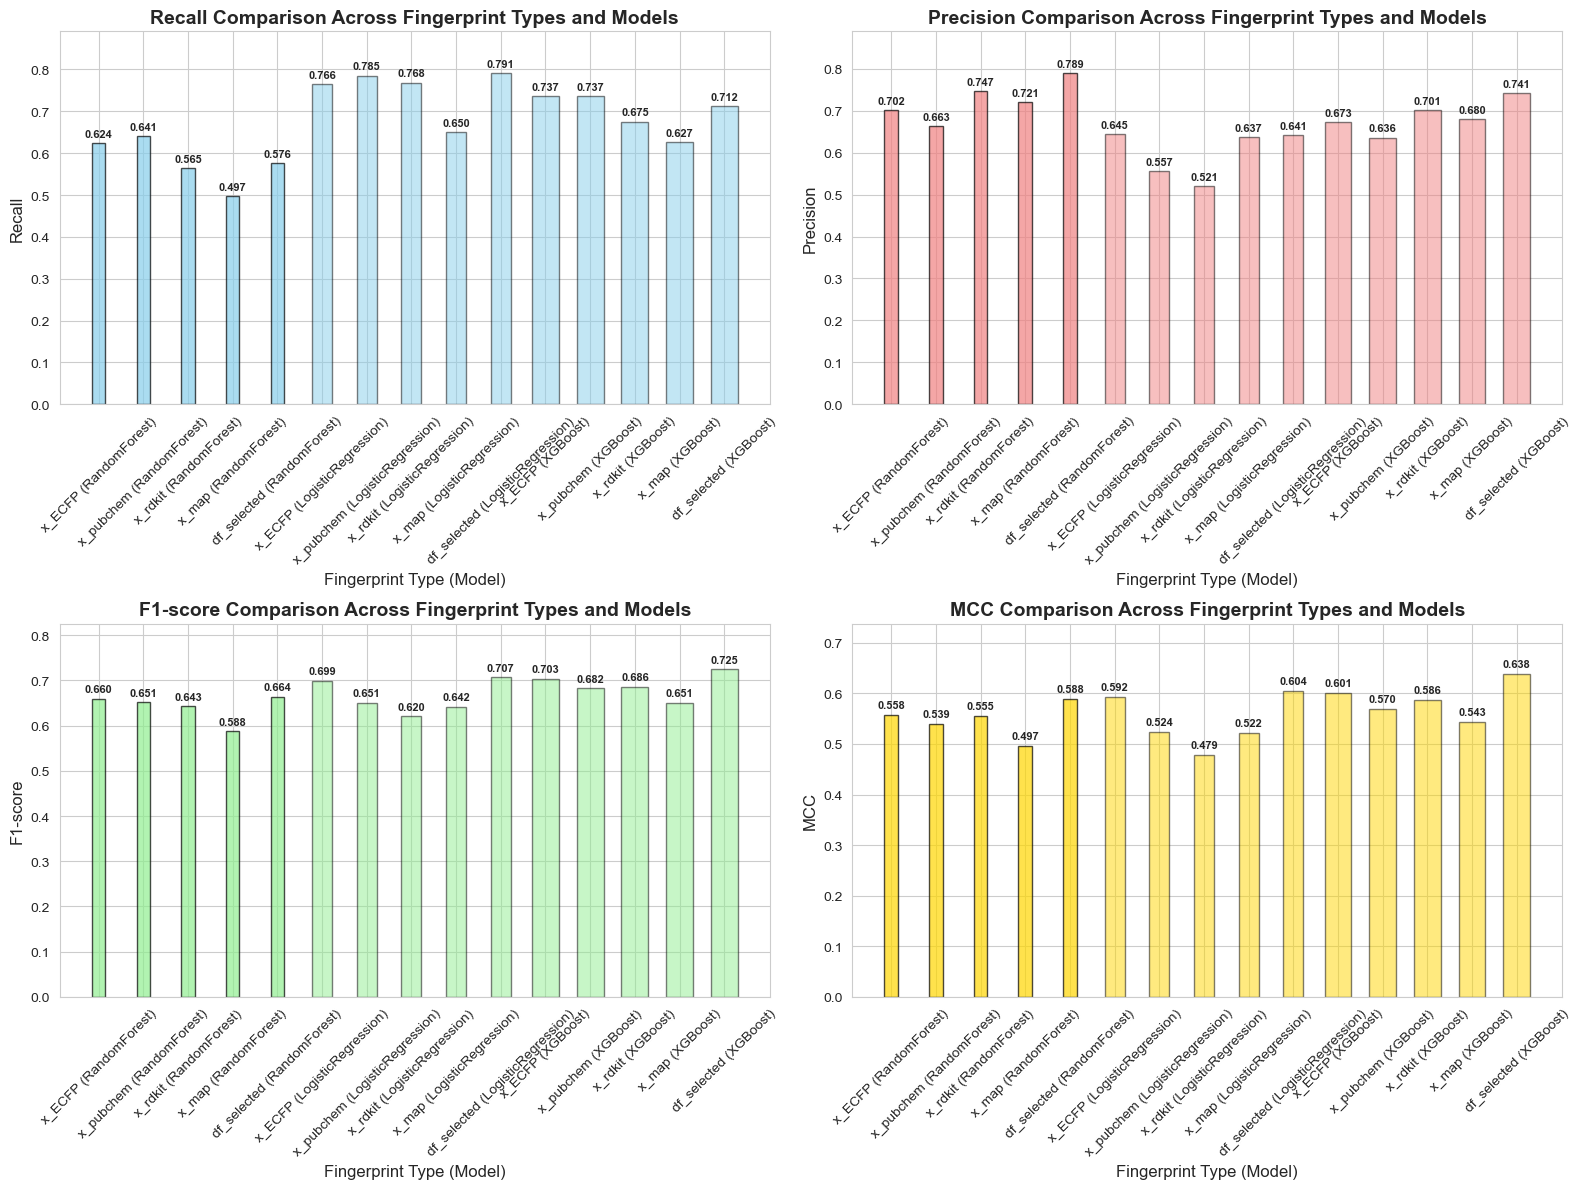

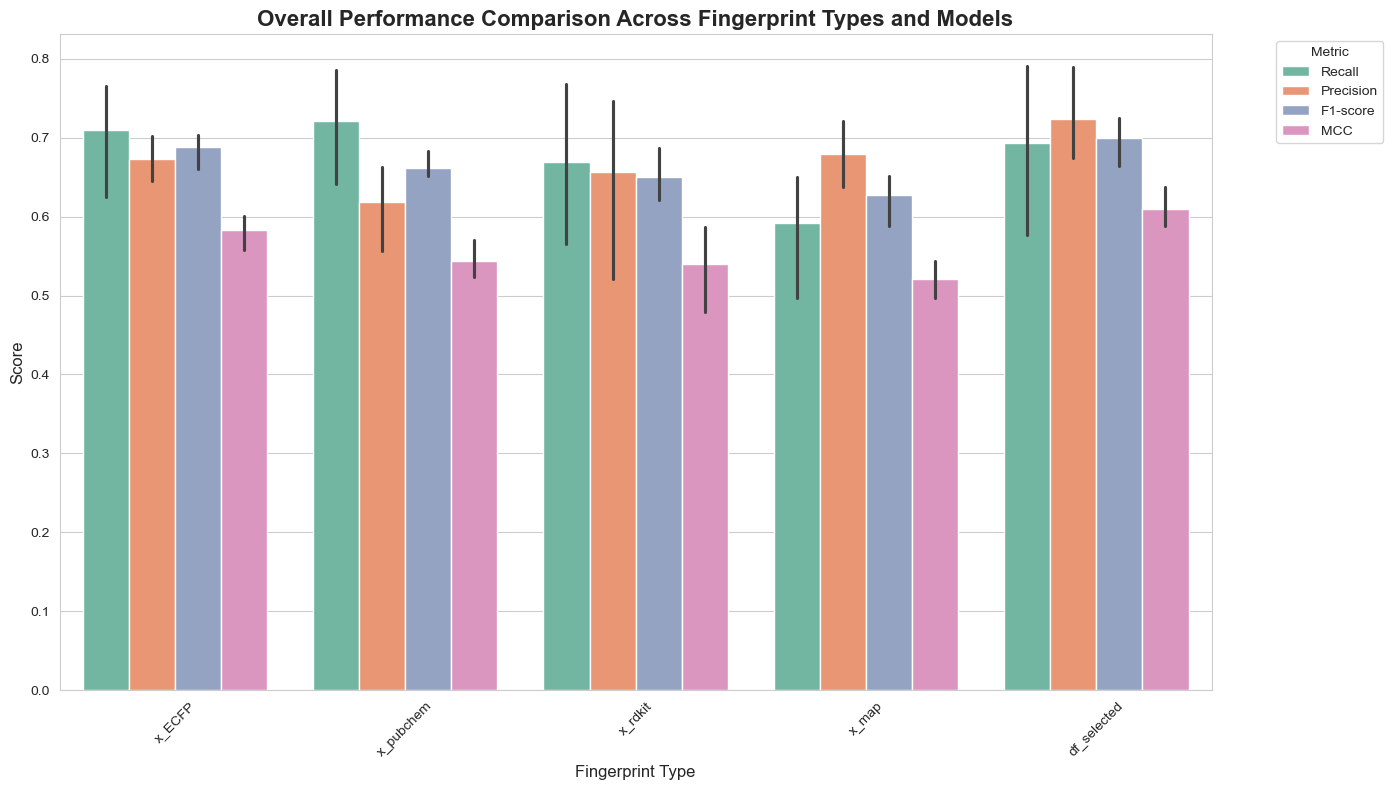

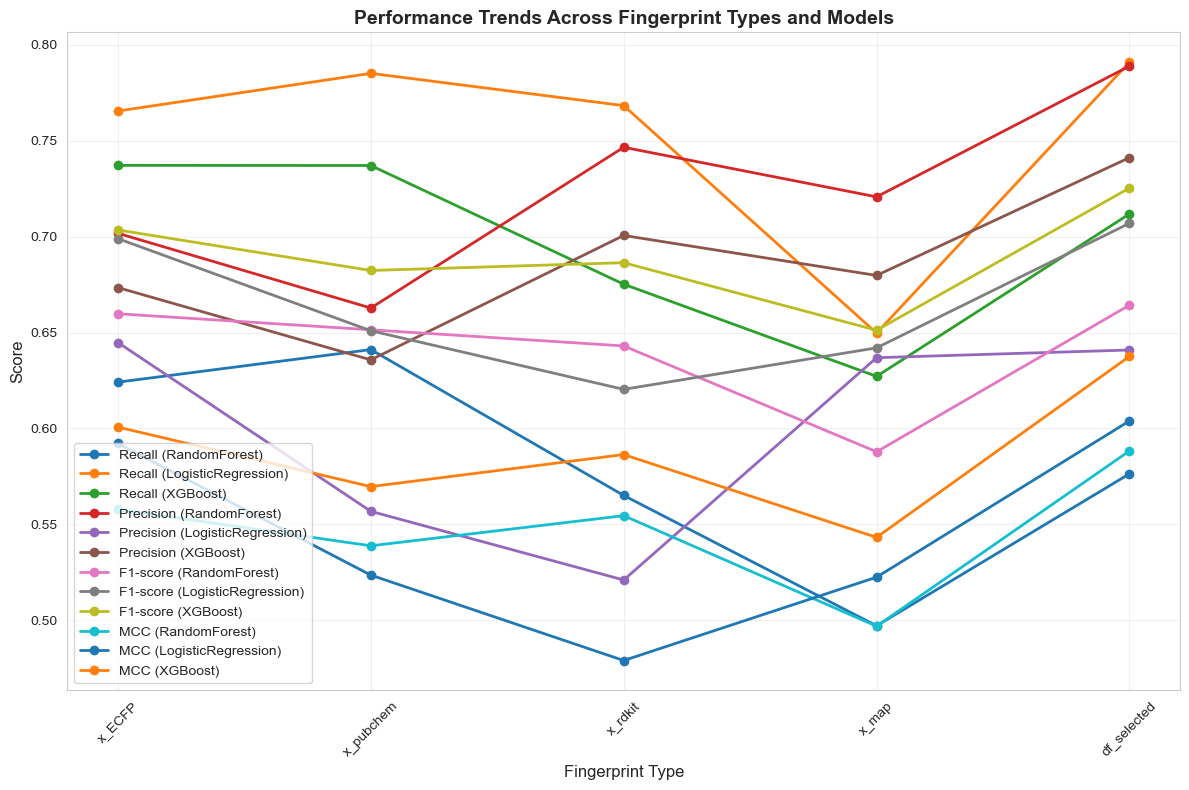

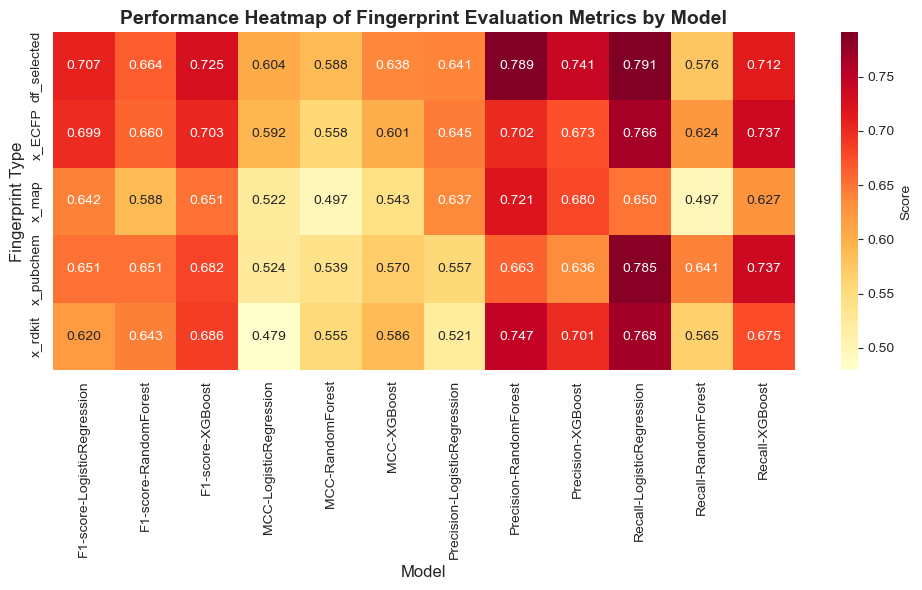

=== Results Summary ===
Fingerprint              Model  Recall  Precision  F1-score    MCC  Recall_std  Precision_std  F1_std  MCC_std
     x_ECFP       RandomForest  0.6241     0.7018    0.6598 0.5578      0.0335         0.0452  0.0315   0.0424
     x_ECFP LogisticRegression  0.7655     0.6448    0.6990 0.5922      0.0486         0.0492  0.0412   0.0579
     x_ECFP            XGBoost  0.7372     0.6734    0.7035 0.6007      0.0186         0.0157  0.0050   0.0068
  x_pubchem       RandomForest  0.6411     0.6628    0.6514 0.5388      0.0305         0.0380  0.0309   0.0417
  x_pubchem LogisticRegression  0.7852     0.5568    0.6509 0.5235      0.0552         0.0338  0.0378   0.0553
  x_pubchem            XGBoost  0.7371     0.6358    0.6824 0.5697      0.0389         0.0361  0.0348   0.0474
    x_rdkit       RandomForest  0.5651     0.7466    0.6430 0.5545      0.0593         0.0774  0.0658   0.0848
    x_rdkit LogisticRegression  0.7683     0.5210    0.6204 0.4790      0.0396         0

In [22]:
# Execute
run_final_comparison_and_plot(fingerprint_dfs, fingerprint_names, activity_col='Activity')

---------------------------
Old